2023/08/17

コイントス問題を最尤推定とベイズ推定の2通りで解く．

# コイントス問題
$N=5$ 回コインを投げて $k=3$ 回表が出た．このコインの表が出る確率は？

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
N = 5
k = 3

- 純真無垢な小学生「1/2に決まってんじゃん．たまたまそうなったんじゃないの？うける」
- 無駄に知識を持ってしまったお前ら「データ上，一番もっともらしい値は3/5だろう．実際はしらんけどな･･･」

そう，最尤推定は無駄に知識を持ったお前らが選ぶ点推定法である．

しかし，1/2かどうかはともかく，小学生の言う通り，真のコイン表率は3/5でなくても観測値は $(N, k) = (5, 3)$ になりうる．
1/2にも3/5にも限らず，任意の表率に対して観測値が $(N, k) = (5, 3)$ になる確率を計算し，その分布を見るのがベイズ推定である．

## ここで唐突に問題の一般化
- 仮定：事象 $X$ が観測された背後にはそれを生成するモデルがあり，そのモデルはパラメータ $\theta$ を持つ．
- 問題：観測した $X$ から $\theta$ を推定したい．
- 2つの方針
  - 点推定：$X$ を観測する確率が最も高い $\theta$ を求める（最尤推定）．
  - 分布推定：任意の $\theta$ に対して $X$ を観測する確率を求める（ベイズ推定）．
    - 現実問題として，どうせ有限のデータサンプルでは点推定であっても $\theta$ は確率的に決まる．
    - ならその分布を見るべきとも考えられる．
- 尤度 $p(X|\theta):$ パラメータが $\theta$ であるときに $X$ を観測する条件付き確率（$\theta$ から $X$ を得ることの尤もらしさ）
  - 最尤推定・ベイズ推定でともに使う．

### 以上を踏まえてコイントス問題を定式化
- $X(N, k):$ $N$ 回中 $k$ 回表が出る事象
- $\theta:$ 表が出る確率
- 尤度 $p(X|\theta) = \binom{N}{k} \theta^k (1-\theta)^{N-k}$
  - 表率が $\theta$ であるときN回中k回表が出る確率なので，2項分布で定義

In [2]:
# 尤度
def likelihood(N, k, θ):
    return math.comb(N, k) * θ**k * (1-θ)**(N-k)

print(likelihood(N, k, 1/2))    # 小学生の尤もらしさ
print(likelihood(N, k, 3/5))    # お前らの尤もらしさ

0.3125
0.3456


たしかにお前らのほうがもっともらしくはある．

## 最尤推定
- step 1. 尤度を最大化する $\theta$ を求める．つまり $\hat{\theta} = \argmax_\theta p(X|\theta).$
  - この問題では尤度を微分すれば解析的に解ける．
  - $\frac{d}{d\theta} p(X|\theta) = 0$ より $\hat{\theta} = \frac{k}{N}$．
- 計算機でやるなら（ヒューリスティック解法）
  - 任意の $\theta$ に対して尤度を計算したり（総当り）
  - 尤度を目的関数として勾配降下したり（近似）

In [3]:
# 総当り解法（あたまわるわる解法）
θs = np.linspace(0, 1, 10000000)
argmax = likelihood(N, k, θs).argmax()
print(θs[argmax])

0.599999959999996


In [4]:
# 勾配降下法
def dθ(N, k, θ, h=1e-5):    # 尤度の微分（数値微分）
    return (likelihood(N, k, θ+h) - likelihood(N, k, θ-h)) / (2*h)

θ = 0.1
for epoch in range(10):
    θ += 0.2 * dθ(N, k, θ)
    print(θ)

0.1450000000599797
0.22679250637132392
0.37521639673214535
0.5729397052389595
0.6108746589367087
0.5950836681800498
0.6021332367822518
0.5990559928076156
0.6004142870230522
0.5998175082782975


たしかに $\theta=0.6$ あたりで最大値を取っている．

## ベイズ推定
- step 1. 事前分布 $p(\theta)$ を適当に決める（パラメータの分布の初期化）．
  - たとえば一様分布 $p(\theta) = 1 (^\forall \theta \in [0, 1])$
- step 2. 正規化定数 $p(X) = \int p(\theta) p(X|\theta) d\theta$ を計算する．
  - 今回は $p(X) = \binom{N}{k} \int_\theta \theta^k (1-\theta)^{N-k} d\theta$
  - 観測が $N=5, k=3$ のとき，$p(X) = \frac{1}{6}$
- step 3. ベイズの定理より，事後分布 $p(\theta|X) = \frac{p(\theta) p(X|\theta)}{p(X)}$ を計算する．
  - 今回は $p(\theta|X) = \frac{\theta^k (1-\theta)^{N-k}}{\int_\theta \theta^k (1-\theta)^{N-k} d\theta}$
  - 観測が $N=5, k=3$ のとき，$p(\theta|X) = 60 \theta^3 (1-\theta)^2$

0.16666666493163274


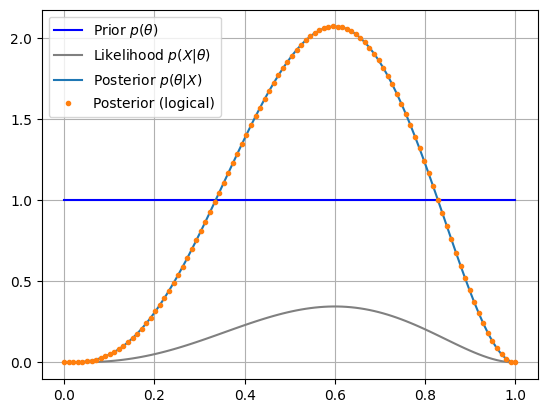

In [8]:
θs = np.linspace(0, 1, 100)
dθ = θs[1] - θs[0]

llh = likelihood(N, k, θs)          # 尤度
prior = np.ones_like(θs)            # step 1. 事前分布
norm = sum(prior * llh * dθ)        # step 2. 正規化定数
posterior = prior * llh / norm      # step 3. 事後分布
logical = 60 * θs**3 * (1-θs)**2    # 事前分布の理論値

print(norm) # 1/6
plt.plot(θs, prior, "b",    label=r"Prior $p(\theta)$")
plt.plot(θs, llh, "gray",   label=r"Likelihood $p(X|\theta)$")
plt.plot(θs, posterior,     label=r"Posterior $p(\theta|X)$")
plt.plot(θs, logical, ".",  label="Posterior (logical)")
plt.legend()
plt.grid()

事前分布が尤度分布につられ，事後分布は $\theta=0.6$ 付近で大きくなっている．

### 事前分布であそぶ（おまけ）
事後分布は事前分布にデータを加えて補正されたものなので，事前分布はまじでなんでもいい．

なんとなく事前分布を $p(\theta) = sin(θπ)$ とかにしてみる（理論値は知らん）．

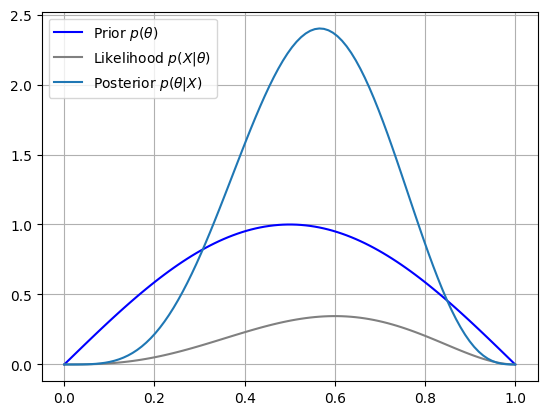

In [6]:
θs = np.linspace(0, 1, 100)
dθ = θs[1] - θs[0]

llh = likelihood(N, k, θs)          # 尤度
prior = np.sin(θs*np.pi)            # step 1. 事前分布
norm = sum(prior * llh * dθ)        # step 2. 正規化定数
posterior = prior * llh / norm      # step 3. 事後分布

plt.plot(θs, prior, "b",    label=r"Prior $p(\theta)$")
plt.plot(θs, llh, "gray",   label=r"Likelihood $p(X|\theta)$")
plt.plot(θs, posterior,     label=r"Posterior $p(\theta|X)$")
plt.legend()
plt.grid()

事前分布が $\theta=0.5$ 付近で高いため，事後分布も最大値が $\theta=0.5$ に近い．

さらに血迷って事前分布を乱数にしてみる．

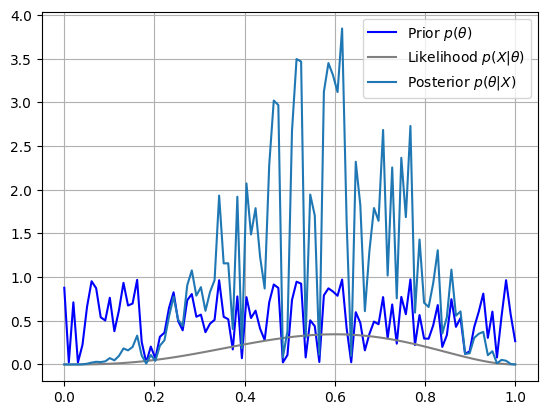

In [7]:
θs = np.linspace(0, 1, 100)
dθ = θs[1] - θs[0]

llh = likelihood(N, k, θs)          # 尤度
prior = np.random.rand(len(θs))     # step 1. 事前分布
norm = sum(prior * llh * dθ)        # step 2. 正規化定数
posterior = prior * llh / norm      # step 3. 事後分布

plt.plot(θs, prior, "b",    label=r"Prior $p(\theta)$")
plt.plot(θs, llh, "gray",   label=r"Likelihood $p(X|\theta)$")
plt.plot(θs, posterior,     label=r"Posterior $p(\theta|X)$")
plt.legend()
plt.grid()

意外といける．